In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sqlite3
import ia636 as ia
import numpy as np
import functions_will as FW
import ia870 as MM
from glob import glob
import nibabel as ni
from skimage import measure
import scipy.misc as misc

/Users/mariecp/DTI_IA369/candidate01
/Users/mariecp/DTI_IA369/candidate01/mpf00.mnc


/Users/mariecp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
/Users/mariecp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


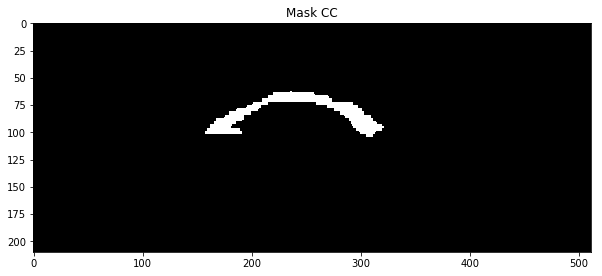

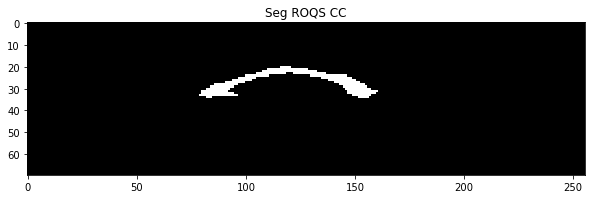

In [22]:
dir_bas = "/Users/mariecp/DTI_IA369"
candidate = str(dir_bas)+"/candidate01"

wFA, FA, MD, fissure, eigvals, eigvects = run_analysis(candidate)
escala = [3*FA[fissure,:,:].shape[-2],2*FA[fissure,:,:].shape[-1]]
wFA_ms = wFA[fissure,:,:]
eigvects_ms = abs(eigvects[0,:,fissure])

#Posicionamento semente
wFA_ss = np.load('/Users/mariecp/DTI_IA369/candidate01/segmentacao/wFA_ss.npy').astype(np.bool)
escala = [wFA_ss.shape[-2],wFA_ss.shape[-1]]
teste = mpimg.imread('/Users/mariecp/DTI_IA369/candidate01/mask_AF.png')[:,:,0]
mask_p3 = np.array(teste).astype(np.bool)
mask_sem = misc.imresize(mask_p3,escala).astype(bool)
con_mask_cc = np.logical_xor(MM.iaero(mask_sem),mask_sem)

seg_mask_seed_ero = MM.iaero(mask_sem)
ar_cc = np.sum(seg_mask_seed_ero)
in_random = np.random.randint(ar_cc)
seed = [np.nonzero(seg_mask_seed_ero)[0][in_random],np.nonzero(seg_mask_seed_ero)[1][in_random]]

#Primeiro critério de seleção: píxels com mesmo maior componente no primeiro autovetor do que a semente

max_comp_in = np.argmax(eigvects_ms[:,seed[0],seed[1]],axis=0)
max_comp_in = np.argmax(ia.iahistogram(max_comp_in))
Cmax_seed = eigvects_ms[max_comp_in,seed[0],seed[1]]

princ = np.argmax(eigvects_ms,axis=0)
fsc = princ == max_comp_in

#Segundo critério de seleção: Aplicação do Magnification Array (MA)

alpha = 0.3
beta = 0.3
gamma = 0.5
FA_ms = FA[fissure]
MA = (FA_ms-np.amax(FA_ms)*alpha)/(np.amax(FA_ms)*beta)+gamma

ssc = np.clip(np.amax(eigvects_ms*MA,axis=0),0,1)
ssc = ssc*fsc

mask_cc = ssc > Cmax_seed-0.1

fr = MM.ialabel(mask_cc)
fra = MM.iablob(fr,'area')
mask_cc = fra == np.unique(fra)[-1]

np.save('/Users/mariecp/DTI_IA369/candidate01/segmentacao/mask_ROQS', mask_cc)



plt.figure(figsize=(10,10))
plt.title('Mask CC')
plt.imshow(teste,cmap='gray')
plt.figure(figsize=(10,10))
plt.title('Seg ROQS CC')
plt.imshow(mask_cc,cmap='gray')


In [11]:
def getFissureSlice(eigvals, FA):
    import numpy as np

    MASK = (eigvals[0]>0)
    MASKcount = MASK.sum(axis=2).sum(axis=1)
    FAmean = FA.mean(axis=2).mean(axis=1)
    FAmean[MASKcount<=0.90*MASKcount.max()] = 1
    return (np.argmin(FAmean), FAmean)

In [12]:
def alignSagittalPlane(T):

    # CANONICAL BASE (i,j,k) (HOMOGENEOUS COORDINATES)
    c = np.array(
        [[0,1,0,0],
         [0,0,1,0],
         [0,0,0,1],
         [1,1,1,1]])

    # FIND BASE V
    V_ = np.dot(T,c)
    V_ = V_[:3,1:] - V_[:3,0].reshape(3,1)

    V = np.zeros((3,3))
    V[np.arange(3),np.argmax(np.abs(V_), axis=1)] = 1
    V_[V_==0] = 1
    V = V * (V_/np.abs(V_))

    # DESIRED BASE W
    W = np.array([[1,0,0],
                  [0,0,-1],
                  [0,-1,0]])

    R = np.dot(np.linalg.inv(W), V)
    r = np.diag(np.ones(4))
    r[:3,:3] = R
    return r

In [13]:
def loadNiftiDTI(basedir, basename='dti', reorient=False):
    from nibabel import nifti1


    # ====== MAIN FUNCTION START ===========================
    # PRE-LOAD THE FIRST EIGENVALUE VOLUME TO GET HEADER PARAMS
    L = ni.load('{}/{}_L1.nii.gz'.format(basedir, basename))
    s,m,n = L.get_data().shape

    # LOAD AND BUILD EIGENVALUES VOLUME
    evl = [L.get_data()]
    evl.append(ni.load('{}/{}_L2.nii.gz'.format(basedir, basename)).get_data())
    evl.append(ni.load('{}/{}_L3.nii.gz'.format(basedir, basename)).get_data())
    evl = np.array(evl)
    evl[evl<0] = 0

    # LOAD AND BUILD EIGENVECTORS VOLUME
    evt = [ni.load('{}/{}_V1.nii.gz'.format(basedir, basename)).get_data()]
    evt.append(ni.load('{}/{}_V2.nii.gz'.format(basedir, basename)).get_data())
    evt.append(ni.load('{}/{}_V3.nii.gz'.format(basedir, basename)).get_data())
    evt = np.array(evt).transpose(0,4,1,2,3)

    T = np.diag(np.ones(4))
    if reorient:
        # GET QFORM AFFINE MATRIX (see Nifti and nibabel specifications)
        T = L.get_header().get_qform()

        # COMPUTE ROTATION MATRIX TO ALIGN SAGITTAL PLANE
        R = alignSagittalPlane(T)
        evl, evt, T = rotateDTI(evl, evt, R)

    return (evl, evt, T)

In [14]:
def getFractionalAnisotropy(eigvals):
    import numpy as np
    MD = eigvals.mean(axis=0)
    FA = np.sqrt(3*((eigvals-MD)**2).sum(axis=0)) / np.sqrt(2*(eigvals**2).sum(axis=0))
    return (FA,MD)

In [15]:
def rotateDTI(evl, evt, R):


    s,m,n = evl[0].shape

    # ====== DETERMINE TARGET DOMAIN SIZE AND A TRANSLATION TO FIT THE ROTATED IMAGE =======
    # VERTICES FROM THE CUBE DEFINING THE ORIGINAL VOLUME
    cube = np.array([[0,0,0,1],
                     [0,0,n,1],
                     [0,m,n,1],
                     [0,m,0,1],
                     [s,m,0,1],
                     [s,0,0,1],
                     [s,0,n,1],
                     [s,m,n,1]]).transpose()

    # COMPUTE THE FIT TRANSLATION AND COMBINE WITH THE ROTATION
    cube = np.dot(R,cube)
    t = -cube.min(axis=1)
    Tr = np.diag(np.ones(4, dtype='float'))
    Tr[:3,3] = t[:3]
    T = np.dot(Tr,R)

    # DEFINE THE TARGET DOMAIN
    cube = cube + t.reshape(4,1)
    domain = np.ceil(cube.max(axis=1))[:3].astype('int')

    # === TRANSFORMATION ===
    invT = np.linalg.inv(T)
    N = domain.prod()

    # GET INDICES IN TARGET SPACE
    points = np.array(np.indices(domain)).reshape(3,N)
    points = np.vstack((points, np.ones(N)))

    # COMPUTE POINT COORDINATES WITH NEAREST NEIGHBOR INTERPOLATION
    points = np.dot(invT, points)[:3]
    points = np.round(points).astype('int')
    out_of_space = np.logical_or(points<0, points>=np.array([s,m,n]).reshape(3,1)).max(axis=0)
    points[:,out_of_space] = 0
    z,y,x = points

    # APPLY TRANSFORMATION TO THE EIGENVALUES VOLUME
    eigenvals = evl[:,z,y,x].copy()
    eigenvals[:,out_of_space] = 0
    eigenvals.shape = (3,) + tuple(domain)

    # APPLY ROTATION TO THE EIGENVECTORS
    evt = evt.copy()
    evt.shape = (3,3,s*m*n)
    for i in xrange(3):
        evt[i] = np.dot(R[:3,:3],evt[i])
    evt.shape = (3,3,s,m,n)

    # APPLY TRANSFORMATION TO THE EIGENVECTORS VOLUME
    eigenvects = evt[:,:,z,y,x]
    eigenvects[:,:,out_of_space] = 0
    eigenvects.shape = (3,3) + tuple(domain)

    return (eigenvals, eigenvects, T)

In [16]:
def run_analysis(rootdir):  

    t1_filename = '{}/t1.nii.gz'.format(rootdir)
    print(rootdir)
    minc_filename = glob('{}/*.mnc'.format(rootdir))[0]
    print(minc_filename)
    tagfilename = glob('{}/*.tag'.format(rootdir))[0]
    brain_mask_filename = '{}/nodif_brain_mask.nii.gz'.format(rootdir)
    tag = np.loadtxt(tagfilename, skiprows=4, comments=';')


    eigvals, eigvects, T3 = loadNiftiDTI(rootdir, reorient=True)

    FA,MD = getFractionalAnisotropy(eigvals)
    FA[np.isnan(FA)] = 0
    FA[FA>1] = 1

    fissure, FA_mean = getFissureSlice(eigvals, FA)

    wFA = FA*abs(eigvects[0,0]) #weighted FA
    
    return wFA, FA, MD, fissure, eigvals, eigvects

In [17]:
def plot_mask(im,mask,mask2,escala,mask_name):
    con_mask = np.logical_xor(mask,MM.iaero(mask))
    con_mask = np.ma.masked_where(con_mask == 0,con_mask)
    con_mask2 = np.logical_xor(mask2,MM.iaero(mask2))
    con_mask2 = np.ma.masked_where(con_mask2==0,con_mask2)
        
    plt.figure()
    plt.axis('off')
    plt.imshow(im,cmap='gray')
    plt.imshow(con_mask,cmap=mpl.cm.jet_r,interpolation='none')
    plt.imshow(con_mask2,cmap=mpl.cm.brg_r,interpolation='none')
    plt.show()